In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

class ImageProcessing:
    def __init__(self, image_path):
        self.image_path = image_path
        self.img = self.load_image(image_path)

    def load_image(self, path):
        img = cv2.imread(path)
        if img is None:
            raise FileNotFoundError(f"Image at path {path} not found or could not be loaded.")
        return img

    def show_image(self, img, title):
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.show()


## HarrisCornerDetection

In [39]:
class HarrisCornerDetection(ImageProcessing):
    def harris_corner_detection(self):
        try:
            gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
            dst = cv2.cornerHarris(np.float32(gray), 2, 3, 0.04)
            self.img[dst > 0.01 * dst.max()] = [0, 0, 255]
            self.show_image(self.img, 'Harris Corner Detection')
        except Exception as e:
            print(f"Error in Harris Corner Detection: {e}")


1.) Grayscale and Detection: Convert the image to grayscale and apply Harris Corner Detection to find corners.

2.) Highlight and Display: Highlight detected corners in red on the original image and display it.

## ImagePyramid

In [41]:
class ImagePyramid(ImageProcessing):
    def image_pyramid(self):
        try:
            layer = self.img.copy()
            gp = [layer]
            for _ in range(5):
                layer = cv2.pyrDown(layer)
                gp.append(layer)
            for i, layer in enumerate(gp):
                plt.subplot(3, 2, i + 1)
                plt.imshow(cv2.cvtColor(layer, cv2.COLOR_BGR2RGB))
                plt.title(f'Layer {i}')
            plt.show()
        except Exception as e:
            print(f"Error in Image Pyramid: {e}")


1) Generate Pyramid: Create an image pyramid by repeatedly applying cv2.pyrDown and store each layer.
2) Display Layers: Plot each pyramid layer in a grid using matplotlib.


## Watershed Segmentation

In [43]:
class WatershedSegmentation(ImageProcessing):
    def watershed_segmentation(self):
        try:
            gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
            ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            kernel = np.ones((3, 3), np.uint8)
            opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
            sure_bg = cv2.dilate(opening, kernel, iterations=3)
            dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
            ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
            sure_fg = np.uint8(sure_fg)
            unknown = cv2.subtract(sure_bg, sure_fg)
            ret, markers = cv2.connectedComponents(sure_fg)
            markers += 1
            markers[unknown == 0] = 0
            markers = cv2.watershed(self.img, markers)
            self.img[markers == -1] = [255, 0, 0]
            self.show_image(self.img, 'Watershed Algorithm')
        except Exception as e:
            print(f"Error in Watershed Segmentation: {e}")


1) Preprocessing: Convert image to grayscale, apply binary threshold, morphological opening, dilation, and distance transform to separate foreground and background.
2) Watershed Segmentation: Compute markers, apply watershed algorithm, and highlight boundaries in the original image.

## SIFT Algorithm

In [45]:
class SIFTAlgorithm(ImageProcessing):
    def sift_algorithm(self):
        try:
            gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
            sift = cv2.SIFT_create()
            keypoints, _ = sift.detectAndCompute(gray, None)
            img_with_keypoints = cv2.drawKeypoints(self.img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            self.show_image(img_with_keypoints, 'SIFT Keypoints')
        except Exception as e:
            print(f"Error in SIFT Algorithm: {e}")


1) Keypoint Detection: Convert the image to grayscale, detect SIFT keypoints.
2) Display Keypoints: Draw and display keypoints on the original image.

## YOLO Object Detection

In [47]:
class YoloObjectDetection(ImageProcessing):
    def __init__(self, image_path, yolo_weights, yolo_cfg, coco_names):
        super().__init__(image_path)
        self.yolo_weights = yolo_weights
        self.yolo_cfg = yolo_cfg
        self.coco_names = coco_names
        self.net = cv2.dnn.readNet(yolo_weights, yolo_cfg)
        self.classes = self.load_classes(coco_names)

    def load_classes(self, path):
        with open(path, 'r') as f:
            return [line.strip() for line in f.readlines()]

    def yolo_object_detection(self):
        try:
            height, width = self.img.shape[:2]
            blob = cv2.dnn.blobFromImage(self.img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
            self.net.setInput(blob)
            outs = self.net.forward([self.net.getLayerNames()[i - 1] for i in self.net.getUnconnectedOutLayers()])
            boxes, confidences, class_ids = [], [], []
            for out in outs:
                for detection in out:
                    scores = detection[5:]
                    class_id = np.argmax(scores)
                    confidence = scores[class_id]
                    if confidence > 0.5:
                        center_x, center_y, w, h = (detection[:4] * [width, height, width, height]).astype(int)
                        x, y = center_x - w // 2, center_y - h // 2
                        boxes.append([x, y, w, h])
                        confidences.append(float(confidence))
                        class_ids.append(class_id)
            indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
            for i in indexes:
                x, y, w, h = boxes[i]
                label = str(self.classes[class_ids[i]])
                cv2.rectangle(self.img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(self.img, label, (x, y + 30), cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), 3)
            self.show_image(self.img, 'YOLO Object Detection')
        except Exception as e:
            print(f"Error in YOLO Object Detection: {e}")


1) Initialize YOLO: Load YOLO weights, config, and class names.
2) Preprocess Image: Convert the image to a blob.
3) Forward Pass: Perform a forward pass through the network to get detections.
4) Filter Detections: Use Non-Maximum Suppression to filter out weak detections.
5) Draw and Display: Draw bounding boxes with labels on the image and display it.

## Print Result

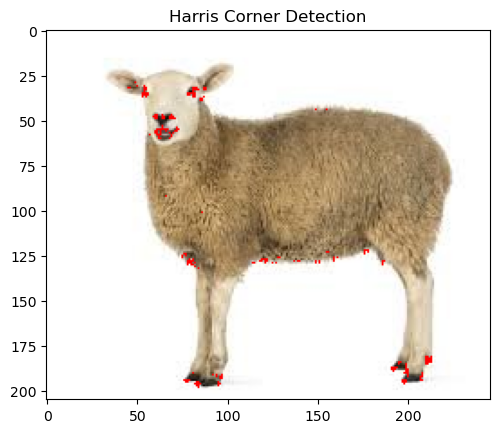

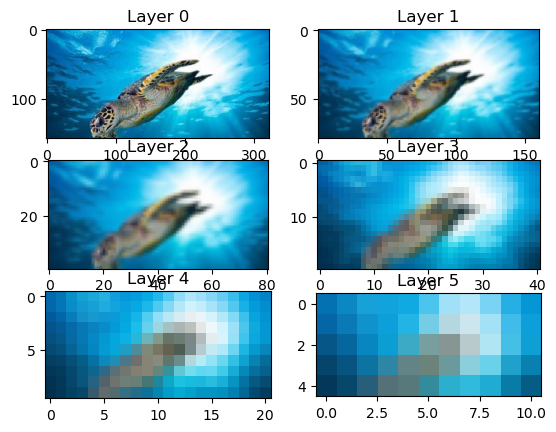

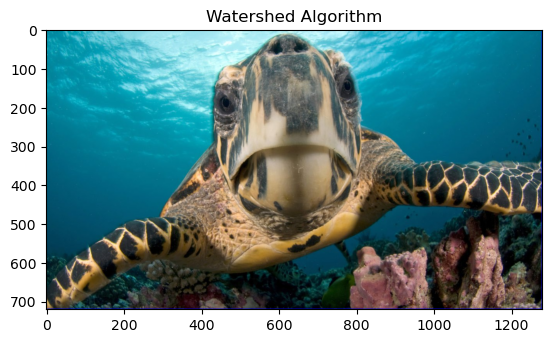

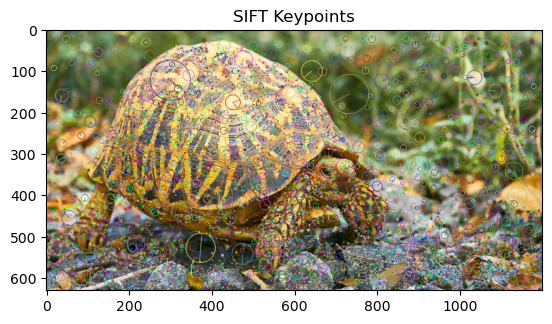

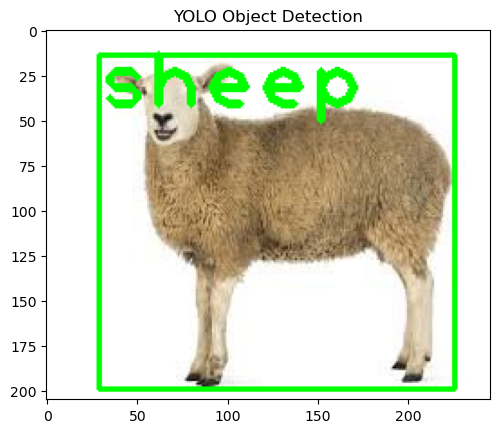

In [51]:
harris = HarrisCornerDetection('0a4f33eab6.jpg')
harris.harris_corner_detection()

pyramid = ImagePyramid('0c81d864f9.jpg')
pyramid.image_pyramid()

watershed = WatershedSegmentation('0d670c7936.jpg')
watershed.watershed_segmentation()

sift = SIFTAlgorithm('0fe508ab40.jpg')
sift.sift_algorithm()

yolo = YoloObjectDetection('0a4f33eab6.jpg', 'yolov3.weights', 'yolov3.cfg', 'coco.names')
yolo.yolo_object_detection()
